In [1]:
import glob,os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
from IPython.display import display, Math
import scipy as sci
import sympy as sp
import scienceplots

def displ(expr,namestr=None):
    if namestr is not None:
        display(Math(sp.latex(namestr)+'='+sp.latex(expr)))
    else:
        display(Math(sp.latex(expr)))

def SymbolSubstitution(expr, exprs: dict, vals = None):

    while not expr.free_symbols.isdisjoint(exprs.keys()):
        syms = expr.free_symbols
        for sym in syms:
            if sym in exprs.keys():
                expr = expr.subs([(sym,exprs[sym])])

    if vals is not None:
        while not expr.free_symbols.isdisjoint(vals.keys()):
            syms = expr.free_symbols
            for sym in syms:
                if sym in vals.keys():
                    expr = expr.subs([(sym,vals[sym])])
    return expr

################################################################################
# Read Bintu:
################################################################################

def READ_BINTU_CSV(filename,dir):
    file = f'{dir}/{filename}'
    lines = [ln[:-1].split(',') for ln in open(file,'r')]
    keep = np.array(list(map(len,lines)))>1
    data = np.array([line for line,kp in zip(lines,keep) if kp][1:],dtype=float)
    nchr=len(np.unique(data[:,0]))
    chrZXY=data[:,2:].reshape(nchr,-1,3)
    return chrZXY/1000


def NonNanPaths(zxys):
    cells=np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])],dtype=int)
    zxys_=[]
    for c in cells:
        zxys_.append(zxys[c])
    return cells,zxys_
    
################################################################################
# Fitting Model:
################################################################################


def GAUSSIAN_DISTR(r,R):
    return 4*np.pi*r**2*(3/(2*np.pi*R**2))**(1.5)*np.exp(-3*r**2/(2*R**2))

def TWO_GAUSSIAN_DISTR(r,R1,R2,f):
    return f*GAUSSIAN_DISTR(r,R1)+(1-f)*GAUSSIAN_DISTR(r,R2)

def power_function(x,a,v):
    return a*x**v

def power_function(x, a, v):
    """
    Calculate a power function.

    Parameters:
    - x (float): The input value.
    - a (float): The coefficient.
    - v (float): The exponent.

    Returns:
    - float: The result of the power function.
    """
    return a * x**v

def PRIMITIVE_GAUSSIAN_DISTR(a,R):
    lam = 3/2/R**2
    return 4*np.pi*(3/(2*np.pi*R**2))**(1.5)*1/4/lam*(np.sqrt(np.pi/lam)*sci.special.erf(a*np.sqrt(lam))-a*np.exp(-a**2*lam))

def PRIMITIVE_TWO_GAUSSIAN_DISTR(a,R1,R2,f):
    return f*PRIMITIVE_GAUSSIAN_DISTR(a,R1)+(1-f)*PRIMITIVE_GAUSSIAN_DISTR(a,R2)

################################################################################
# Interpolation BINTU
################################################################################

def interp1dnan(A):
    A_=np.array(A)
    missing = np.isnan(A)
    nonmissing = ~missing
    xp = np.where(nonmissing)[0]
    fp = A[nonmissing]
    x  = np.where(missing)[0]
    A_[missing] = np.interp(x, xp, fp)
    return A_

def plot_map(zxy,interpolate=True):
    """
    We can interpolate across positions we do not have data (too dim to reliably fit).
    We mark those positions as white on the diagonal.
    """
    zxy_ = np.array(zxy)
    if interpolate:
        zxy_ = np.array(list(map(interp1dnan,zxy.T))).T
        bad = np.where(np.isnan(zxy[:,0]))[0]
    mat_ = squareform(pdist(zxy_))
    mat_[bad,bad]=np.nan
    plt.imshow(-mat_,interpolation='nearest',cmap='seismic',vmin=-1000,vmax=0)

def interpolate_zxy(zxy,interpolate=True):
    zxy_ = np.array(zxy)
    if interpolate:
        zxy_ = np.array(list(map(interp1dnan,zxy.T))).T
    return zxy_

def INTERPOLATE_ZXY(ZXY):
    ncells,ntags,ncoor=ZXY.shape
    ZXY_=np.zeros((ncells,ntags,ncoor))
    for cell in range(ncells):
        try: 
            ZXY_[cell]=interpolate_zxy(ZXY[cell])
        except:
            print(f'Problem could not be resolved for cell{cell}')
    return ZXY_

def RadiusOfGyration(zxy,n,interpolate=False):
    if interpolate: zxy=interpolate_zxy(zxy)
    ps=[]
    rg=[]
    i=0
    while i+n<len(zxy):
        rg.append(np.sqrt(np.sum(np.var(zxy[i:i+n],axis=0))))
        i+=1
        ps.append((2*i+n-1)/2)
    return np.array(ps),np.array(rg)    

def RadiusOfGyration_cell_line(zxys,n,interpolate=False):
    ncells=len(zxys)
    Rg=[]
    for c in range(ncells):
        zxy=zxys[c]
        ps,rg=RadiusOfGyration(zxy,n=n,interpolate=interpolate)
        Rg.append(rg)
    return ps,np.array(Rg)

def Fitting_TWO_GAUSSIAN_DISTR(dist,bins = np.linspace(0,1.2,25)):
    hist = np.histogram(dist,bins=bins,density=True)
    bc = 0.5*(bins[1:]+bins[:-1])
    param =  sci.optimize.curve_fit(TWO_GAUSSIAN_DISTR,bc,hist)[0]
    return param

def Fitting_GAUSSIAN_DISTR(dist,bins = np.linspace(0,1.2,25)):
    hist = np.histogram(dist,bins=bins,density=True)[0]
    bc = 0.5*(bins[1:]+bins[:-1])
    param,pcov =  sci.optimize.curve_fit(GAUSSIAN_DISTR,bc,hist)
    return param


## Reading data

In [2]:
path = '5kb_res_trace.mat'
dic = sci.io.loadmat(path)
dat = dic['Chr'][0]
print(dic['Chr'].dtype)

[('x', 'O'), ('y', 'O'), ('z', 'O'), ('r', 'O'), ('CellType', 'O'), ('RNACopyNumber', 'O'), ('MeanYWGA', 'O'), ('MeanXWGA', 'O'), ('FOV', 'O'), ('DatasetID', 'O')]


## Extract XYZ-data
We extract xyz positions for 19 5-kb loci upstream of promotor Scd2.
We identified cell type 3 as hepatocyte cell types. And cell types 8 as Unknown.

In [3]:
RESULTS = { 'Other' : {'cellID' : [1]},
            'Endothial' : {'cellID' : [2]},
            'Hepatocyte' : {'cellID': [3]},
            'Macrophage' : {'cellID' : [4]},
            'Megakaryocyte' : {'cellID' : [5]},
            'Erythroblast' : {'cellID' : [6]},
            'Proerythroblast' : {'cellID' : [7]},            
            'Unknown' : {'cellID': [8]}, 
            'Non-Hepatocyte' : {'cellID': [1,2,4,5,6,7]},
            'all' : {'cellID': [1,2,3,4,5,6,7,8]} 
          }

cell_lines = list(RESULTS.keys())
print(cell_lines)

['Other', 'Endothial', 'Hepatocyte', 'Macrophage', 'Megakaryocyte', 'Erythroblast', 'Proerythroblast', 'Unknown', 'Non-Hepatocyte', 'all']


In [4]:

for cell_line in cell_lines:
    XYZ = []
    for i in range(len(dat)):
        if dat[i][4][0,0] in RESULTS[cell_line]['cellID']:
            xyz = np.hstack((dat[i][0],dat[i][1],dat[i][2]))
            XYZ.append(np.hstack((dat[i][0],dat[i][1],dat[i][2])))

    XYZ = np.array(XYZ)
    for i,xyz in enumerate(XYZ):
        for j,pos in enumerate(xyz):
            if sum(abs(pos)) == 0:
                XYZ[i,j] = ['nan','nan','nan']
    RESULTS[cell_line]['xyz'] = XYZ
    RESULTS[cell_line]['distmat'] = np.array(list(map(squareform,map(pdist,XYZ))))
    print(np.shape(RESULTS[cell_line]['distmat']))
np.save('results_liu.npy',RESULTS,allow_pickle=True)

(259, 19, 19)
(225, 19, 19)
(1491, 19, 19)
(343, 19, 19)
(68, 19, 19)
(2078, 19, 19)
(1212, 19, 19)
(1536, 19, 19)
(4185, 19, 19)
(7212, 19, 19)


## Distance distributions and the two phase model

## Scaling laws

In [5]:
def power_law(x,nu,a):
    return a*x**nu

In [6]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import scipy.io

# Define the RESULTS dictionary with cell IDs for each cell line
RESULTS = {
    'Other': {'cellID': [1]},
    'Endothial': {'cellID': [2]},
    'Hepatocyte': {'cellID': [3]},
    'Macrophage': {'cellID': [4]},
    'Megakaryocyte': {'cellID': [5]},
    'Erythroblast': {'cellID': [6]},
    'Proerythroblast': {'cellID': [7]},
    'Unknown': {'cellID': [8]},
    'Non-Hepatocyte': {'cellID': [1, 2, 4, 5, 6, 7]},
    'all': {'cellID': [1, 2, 3, 4, 5, 6, 7, 8]}
}

# Load the data
path = 'Data/5kb_res_trace.mat'
dic = scipy.io.loadmat(path)
dat = dic['Chr'][0]

# Extract XYZ data and compute distance matrices
for cell_line in RESULTS.keys():
    XYZ = []
    for i in range(len(dat)):
        if dat[i][4][0, 0] in RESULTS[cell_line]['cellID']:
            xyz = np.hstack((dat[i][0], dat[i][1], dat[i][2]))
            XYZ.append(xyz)

    XYZ = np.array(XYZ)
    for i, xyz in enumerate(XYZ):
        for j, pos in enumerate(xyz):
            if np.sum(np.abs(pos)) == 0:
                XYZ[i, j] = [np.nan, np.nan, np.nan]
    
    RESULTS[cell_line]['xyz'] = XYZ
    RESULTS[cell_line]['distmat'] = np.array(list(map(squareform, map(pdist, XYZ))))

# Save the RESULTS dictionary
np.save('results_liu.npy', RESULTS, allow_pickle=True)

In [7]:
import numpy as np
from scipy.optimize import curve_fit

# Define the Gaussian and two-Gaussian distribution functions
def GAUSSIAN_DISTR(r, R):
    return 4 * np.pi * r**2 * (3 / (2 * np.pi * R**2))**(1.5) * np.exp(-3 * r**2 / (2 * R**2))

def TWO_GAUSSIAN_DISTR(r, R1, R2, f):
    return f * GAUSSIAN_DISTR(r, R1) + (1 - f) * GAUSSIAN_DISTR(r, R2)

# Update the fitting loop
for cl, cell_line in enumerate(['Other', 'Endothial', 'Hepatocyte', 'Macrophage', 'Megakaryocyte', 'Erythroblast', 'Proerythroblast', 'Unknown', 'Non-Hepatocyte', 'all']):
    distance_mats = RESULTS[cell_line]['distmat']

    ni = np.linspace(0, distance_mats.shape[1] - 1, distance_mats.shape[1], dtype=int)
    nj = np.linspace(0, distance_mats.shape[1] - 1, distance_mats.shape[1], dtype=int)
    bins = np.linspace(0, 1.8, 25)

    Re1_matrix = np.zeros((len(ni), len(nj)))
    Re2_matrix = np.zeros((len(ni), len(nj)))
    fr_matrix = np.zeros((len(ni), len(nj)))
    Rg_matrix = np.zeros((len(ni), len(nj)))

    for i in range(len(ni)):
        for j in range(i, len(nj)):
            nx = ni[i]
            ny = nj[j]

            datah = np.array(distance_mats[:, nx, ny])
            nn, bins = np.histogram(datah, bins)

            b0 = bins[0]
            bins2 = []
            deltab = []

            for bb in bins[1:]:
                bins2.append((bb + b0) / 2)
                deltab.append(bb - b0)
                b0 = bb

            if np.sum(nn) == 0:
                continue
            else:
                bins2 = np.array(bins2)  # Convert bins2 to numpy array

            try:
                # Fit with one Gaussian
                popt1, pcov1 = curve_fit(GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn), bounds=([0], [0.6]), maxfev=10000)
                Rg = popt1[0]
                Rg_matrix[i, j] = np.round(Rg, 2)
                Rg_matrix[j, i] = Rg_matrix[i, j]

                popt2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn),
                                        bounds=([0,0,0],[0.5,0.6,1]), maxfev=10000)  # R1 bounds: (0.05, 1.0) , R2 bounds: (0.05, 1.5)

                Re1 = min(popt2[0], popt2[1])
                Re2 = max(popt2[0], popt2[1])
                if Re1 == popt2[0]:
                    fr = popt2[2]
                else:
                    fr = 1 - popt2[2]

                Re1_matrix[i, j] = np.round(Re1, 2)
                Re2_matrix[i, j] = np.round(Re2, 2)
                fr_matrix[i, j] = fr

                # Use symmetry to avoid redundant fitting
                Re1_matrix[j, i] = Re1_matrix[i, j]
                Re2_matrix[j, i] = Re2_matrix[i, j]
                fr_matrix[j, i] = fr_matrix[i, j]

            except RuntimeError as e:
                print(f"RuntimeError for cell line {cell_line} at indices ({i}, {j}): {e}")
                continue

    RESULTS[cell_line]['Re1_matrix'] = Re1_matrix
    RESULTS[cell_line]['Re2_matrix'] = Re2_matrix
    RESULTS[cell_line]['fr_matrix'] = fr_matrix
    RESULTS[cell_line]['Rg_matrix'] = Rg_matrix

    # Raw mean values:
    RESULTS[cell_line]['Rt_matrix'] = np.round(np.sqrt(np.nanmean(distance_mats**2, axis=0)), 2)
    RESULTS[cell_line]['Median_matrix'] = np.round(np.nanmedian(distance_mats, axis=0), 2)
    print(cell_line, ': done')

Other : done
Endothial : done
Hepatocyte : done
Macrophage : done
Megakaryocyte : done
Erythroblast : done
Proerythroblast : done
Unknown : done
Non-Hepatocyte : done
all : done


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# 
# # Define the Gaussian and two-Gaussian distribution functions
# def GAUSSIAN_DISTR(r, R):
#     return 4 * np.pi * r**2 * (3 / (2 * np.pi * R**2))**(1.5) * np.exp(-3 * r**2 / (2 * R**2))
# 
# def TWO_GAUSSIAN_DISTR(r, R1, R2, f):
#     return f * GAUSSIAN_DISTR(r, R1) + (1 - f) * GAUSSIAN_DISTR(r, R2)
# 
# # Select 15 random pairs of indices
# np.random.seed(42)  # For reproducibility
# num_pairs = 15
# distance_mats = RESULTS['all']['distmat']
# n = distance_mats.shape[1]
# random_indices = np.random.choice(n, (num_pairs, 2), replace=False)
# 
# # Initialize the figure
# fig, axes = plt.subplots(3, 5, figsize=(20, 12))
# axes = axes.flatten()
# 
# # Iterate over the selected indices and plot the fitted PDFs
# for ax, (i, j) in zip(axes, random_indices):
#     distances = distance_mats[:, i, j]
#     bins = np.linspace(0, 1.8, 25)
#     hist, bin_edges = np.histogram(distances, bins=bins, density=True)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# 
#     # Fit the Gaussian distribution
#     try:
#         popt1, _ = curve_fit(GAUSSIAN_DISTR, bin_centers, hist, bounds=([0], [0.6]), maxfev=10000)
#         Rg = popt1[0]
#         ax.plot(bin_centers, GAUSSIAN_DISTR(bin_centers, Rg), lw=2, color='tab:blue', label=f'Gaussian R={np.round(Rg, 2)}')
#     except RuntimeError:
#         pass
# 
#     # Fit the two-Gaussian distribution
#     try:
#         popt2, _ = curve_fit(TWO_GAUSSIAN_DISTR, bin_centers, hist, bounds=([0, 0, 0], [0.5, 0.6, 1]), maxfev=10000)
#         Re1, Re2, fr = popt2
#         ax.plot(bin_centers, TWO_GAUSSIAN_DISTR(bin_centers, Re1, Re2, fr), lw=2, color='tab:green', label=f'Two-Gaussian R1={np.round(Re1, 2)}, R2={np.round(Re2, 2)}')
#     except RuntimeError:
#         pass
# 
#     # Plot the histogram
#     ax.hist(distances, bins=bins, density=True, color='skyblue', alpha=0.5, edgecolor='black')
#     ax.set_xlim(0, 1.8)
#     ax.set_ylim(0, 3)
#     ax.tick_params(axis='both', which='both', labelsize=12, direction='in', top=True, right=True, left=True, bottom=True, length=6, width=1.5)
#     ax.grid(False)
#     ax.text(0.5, 0.9, f'({i}, {j})', transform=ax.transAxes, fontsize=12, ha='center')
#     ax.legend(fontsize=10)
# 
# # Adjust the layout for better presentation
# plt.tight_layout(pad=1)
# plt.show()

In [9]:
import numpy as np
from scipy.optimize import curve_fit

# Filter out inf and NaN values from the data
def filter_invalid_values(x, y):
    valid_indices = np.isfinite(y)
    return x[valid_indices], y[valid_indices]



# Define the number of cell lines
cell_lines = ['Other', 'Endothial', 'Hepatocyte', 'Macrophage', 'Megakaryocyte', 'Erythroblast', 'Proerythroblast', 'Unknown', 'Non-Hepatocyte', 'all']

for cl, cell_line in enumerate(cell_lines):
    Re1_matrix = RESULTS[cell_line]['Re1_matrix']
    Re2_matrix = RESULTS[cell_line]['Re2_matrix']
    Rt_matrix = RESULTS[cell_line]['Rt_matrix']
    Rg_matrix = RESULTS[cell_line]['Rg_matrix']
    fr_matrix = RESULTS[cell_line]['fr_matrix']

    mean_values_fa = []
    std_values_fa = []
    
    mean_values_Ra = []
    std_values_Ra = []

    mean_values_Rb = []
    std_values_Rb = []

    mean_values_Rt = []
    std_values_Rt = []

    mean_values_Rg = []
    std_values_Rg = []

    x_range = range(1, Re1_matrix.shape[1] - 1)
    ss = np.array(x_range) * 5000  # Genomic distances

    # Calculate the mean and std for each i and i + x pair for Ra and Rb
    for x in x_range:
        mean_Ra = np.mean([Re1_matrix[i, i + x] for i in range(Re1_matrix.shape[0] - x)])
        mean_Rb = np.mean([Re2_matrix[i, i + x] for i in range(Re2_matrix.shape[0] - x)])
        mean_Rt = np.mean([Rt_matrix[i, i + x] for i in range(Rt_matrix.shape[0] - x)])
        mean_Rg = np.mean([Rg_matrix[i, i + x] for i in range(Rg_matrix.shape[0] - x)])

        std_Ra = np.std([Re1_matrix[i, i + x] for i in range(Re1_matrix.shape[0] - x)])
        std_Rb = np.std([Re2_matrix[i, i + x] for i in range(Re2_matrix.shape[0] - x)])
        std_Rt = np.std([Rt_matrix[i, i + x] for i in range(Rt_matrix.shape[0] - x)])
        std_Rg = np.std([Rg_matrix[i, i + x] for i in range(Rg_matrix.shape[0] - x)])

        mean_values_Ra.append(mean_Ra)
        mean_values_Rb.append(mean_Rb)
        mean_values_Rt.append(mean_Rt)
        mean_values_Rg.append(mean_Rg)
        mean_values_fa.append(np.mean([fr_matrix[i, i + x] for i in range(fr_matrix.shape[0] - x)]))

        std_values_Ra.append(std_Ra)
        std_values_Rb.append(std_Rb)
        std_values_Rt.append(std_Rt)
        std_values_Rg.append(std_Rg)
        std_values_fa.append(np.std([fr_matrix[i, i + x] for i in range(fr_matrix.shape[0] - x)]))

    mean_values_fa = np.array(mean_values_fa)
    std_values_fa = np.array(std_values_fa)

    f_lower = mean_values_fa - std_values_fa
    f_upper = mean_values_fa + std_values_fa

    fr_vs_distance = np.array([mean_values_fa, f_lower, f_upper])
    RESULTS[cell_line]['fr_vs_distance'] = fr_vs_distance

    mean_values_Ra = np.array(mean_values_Ra)
    std_values_Ra = np.array(std_values_Ra)

    mean_values_Rb = np.array(mean_values_Rb)
    std_values_Rb = np.array(std_values_Rb)

    mean_values_Rt = np.array(mean_values_Rt)
    std_values_Rt = np.array(std_values_Rt)

    mean_values_Rg = np.array(mean_values_Rg)
    std_values_Rg = np.array(std_values_Rg)

    Ra_lower = mean_values_Ra - std_values_Ra
    Ra_upper = mean_values_Ra + std_values_Ra

    Rb_lower = mean_values_Rb - std_values_Rb
    Rb_upper = mean_values_Rb + std_values_Rb

    Rt_lower = mean_values_Rt - std_values_Rt
    Rt_upper = mean_values_Rt + std_values_Rt

    Rg_lower = mean_values_Rg - std_values_Rg
    Rg_upper = mean_values_Rg + std_values_Rg

    Reconstructed_R = np.sqrt(mean_values_Ra**2 * mean_values_fa + mean_values_Rb**2 * (1 - mean_values_fa))

    # Define ss and n after mean_values_Ra and mean_values_Rb are calculated
    n = len(ss)  # Length of the data to fit

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra
    max_ss_Ra = 2 * 10**5
    filtered_indices_Ra = ss <= max_ss_Ra

    ss_filtered_Ra = ss[filtered_indices_Ra]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices_Ra]

    # Filter the data to include only points where ss <= 2 * 10^5 for Rb
    max_ss_Rb = 2 * 10**5
    filtered_indices_Rb = ss <= max_ss_Rb

    ss_filtered_Rb = ss[filtered_indices_Rb]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices_Rb]

    # Fit the power function to the filtered data for Ra and Rb
    pa, pcov = curve_fit(power_function, ss_filtered_Ra, mean_values_Ra_filtered)
    pb, pcov = curve_fit(power_function, ss_filtered_Rb, mean_values_Rb_filtered)

    vu_T = [0, 0]
    vu_eff = [0, 0]
    vu_g = [0, 0]

    # Loop over the range of x values
    for x in range(2, len(mean_values_Rt)):
        # Filter the ss and mean_values_Rt data
        ss_filtered = ss[:x]
        mean_values_Rt_filtered = mean_values_Rt[:x]
        Reconstructed_R_filtered = Reconstructed_R[:x]
        mean_values_Rg_filtered = mean_values_Rg[:x]
        # Fit the power function to the filtered data
        try:
            pt, pcov = curve_fit(power_function, ss_filtered, mean_values_Rt_filtered)
            pg, pcov = curve_fit(power_function, ss_filtered, mean_values_Rg_filtered)
            peff, pcov = curve_fit(power_function, ss_filtered, Reconstructed_R_filtered)
        except:
            print('Error in fitting')

        # Append the fitted exponent to vu_T
        vu_T.append(pt[1])
        vu_g.append(pg[1])
        vu_eff.append(peff[1])

    # Store the results in the existing dictionary with keys ending in _vs_gd
    RESULTS[cell_line].update({
        'mean_values_fa_vs_gd': mean_values_fa,
        'std_values_fa_vs_gd': std_values_fa,
        'mean_values_Ra_vs_gd': mean_values_Ra,
        'std_values_Ra_vs_gd': std_values_Ra,
        'mean_values_Rb_vs_gd': mean_values_Rb,
        'std_values_Rb_vs_gd': std_values_Rb,
        'mean_values_Rt_vs_gd': mean_values_Rt,
        'std_values_Rt_vs_gd': std_values_Rt,
        'mean_values_Rg_vs_gd': mean_values_Rg,
        'std_values_Rg_vs_gd': std_values_Rg,
        'Ra_lower_vs_gd': Ra_lower,
        'Ra_upper_vs_gd': Ra_upper,
        'Rb_lower_vs_gd': Rb_lower,
        'Rb_upper_vs_gd': Rb_upper,
        'Rt_lower_vs_gd': Rt_lower,
        'Rt_upper_vs_gd': Rt_upper,
        'Rg_lower_vs_gd': Rg_lower,
        'Rg_upper_vs_gd': Rg_upper,
        'Reconstructed_R_vs_gd': Reconstructed_R,
        'vu_T_vs_gd': vu_T,
        'vu_eff_vs_gd': vu_eff,
        'vu_g_vs_gd': vu_g
    })

    print(cell_line, ': done')

Other : done
Endothial : done
Hepatocyte : done
Macrophage : done
Megakaryocyte : done
Erythroblast : done
Proerythroblast : done
Unknown : done
Non-Hepatocyte : done
all : done


/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/2259118747.py:132: OptimizeWarning: Covariance of the parameters could not be estimated
  pt, pcov = curve_fit(power_function, ss_filtered, mean_values_Rt_filtered)
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/2259118747.py:133: OptimizeWarning: Covariance of the parameters could not be estimated
  pg, pcov = curve_fit(power_function, ss_filtered, mean_values_Rg_filtered)
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/2259118747.py:134: OptimizeWarning: Covariance of the parameters could not be estimated
  peff, pcov = curve_fit(power_function, ss_filtered, Reconstructed_R_filtered)


A =  0.02202923846588934 B =  0.2020004839713716 B/A =  9.169653516809241
A =  0.0070081508489047714 B =  0.12368550414842364 B/A =  17.648807340919767
A =  0.009199948504045015 B =  0.07506982483863901 B/A =  8.15980924302266
A =  0.004453904460892105 B =  0.11717120856501143 B/A =  26.30752626012601
A =  0.020695350533424254 B =  0.10969866693052718 B/A =  5.30064309630113
A =  0.006410713004693892 B =  0.11486197542878658 B/A =  17.91719194802282
A =  0.009110656668813307 B =  0.09873170356842495 B/A =  10.836947012435832
A =  0.008381836256076101 B =  0.083883933070065 B/A =  10.007822928926398
A =  0.00766215342686146 B =  0.07644327193488235 B/A =  9.976734695352443
A =  0.007862522376867277 B =  0.07870505353290409 B/A =  10.010153200258761


/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/3851395251.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, ss.max())
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/3851395251.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, ss.max())
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/3851395251.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, ss.max())
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/3851395251.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, ss.max())
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/3851395251.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, ss.max())
/var/folders/tq/dgzmpwks2bd9glbd8wt

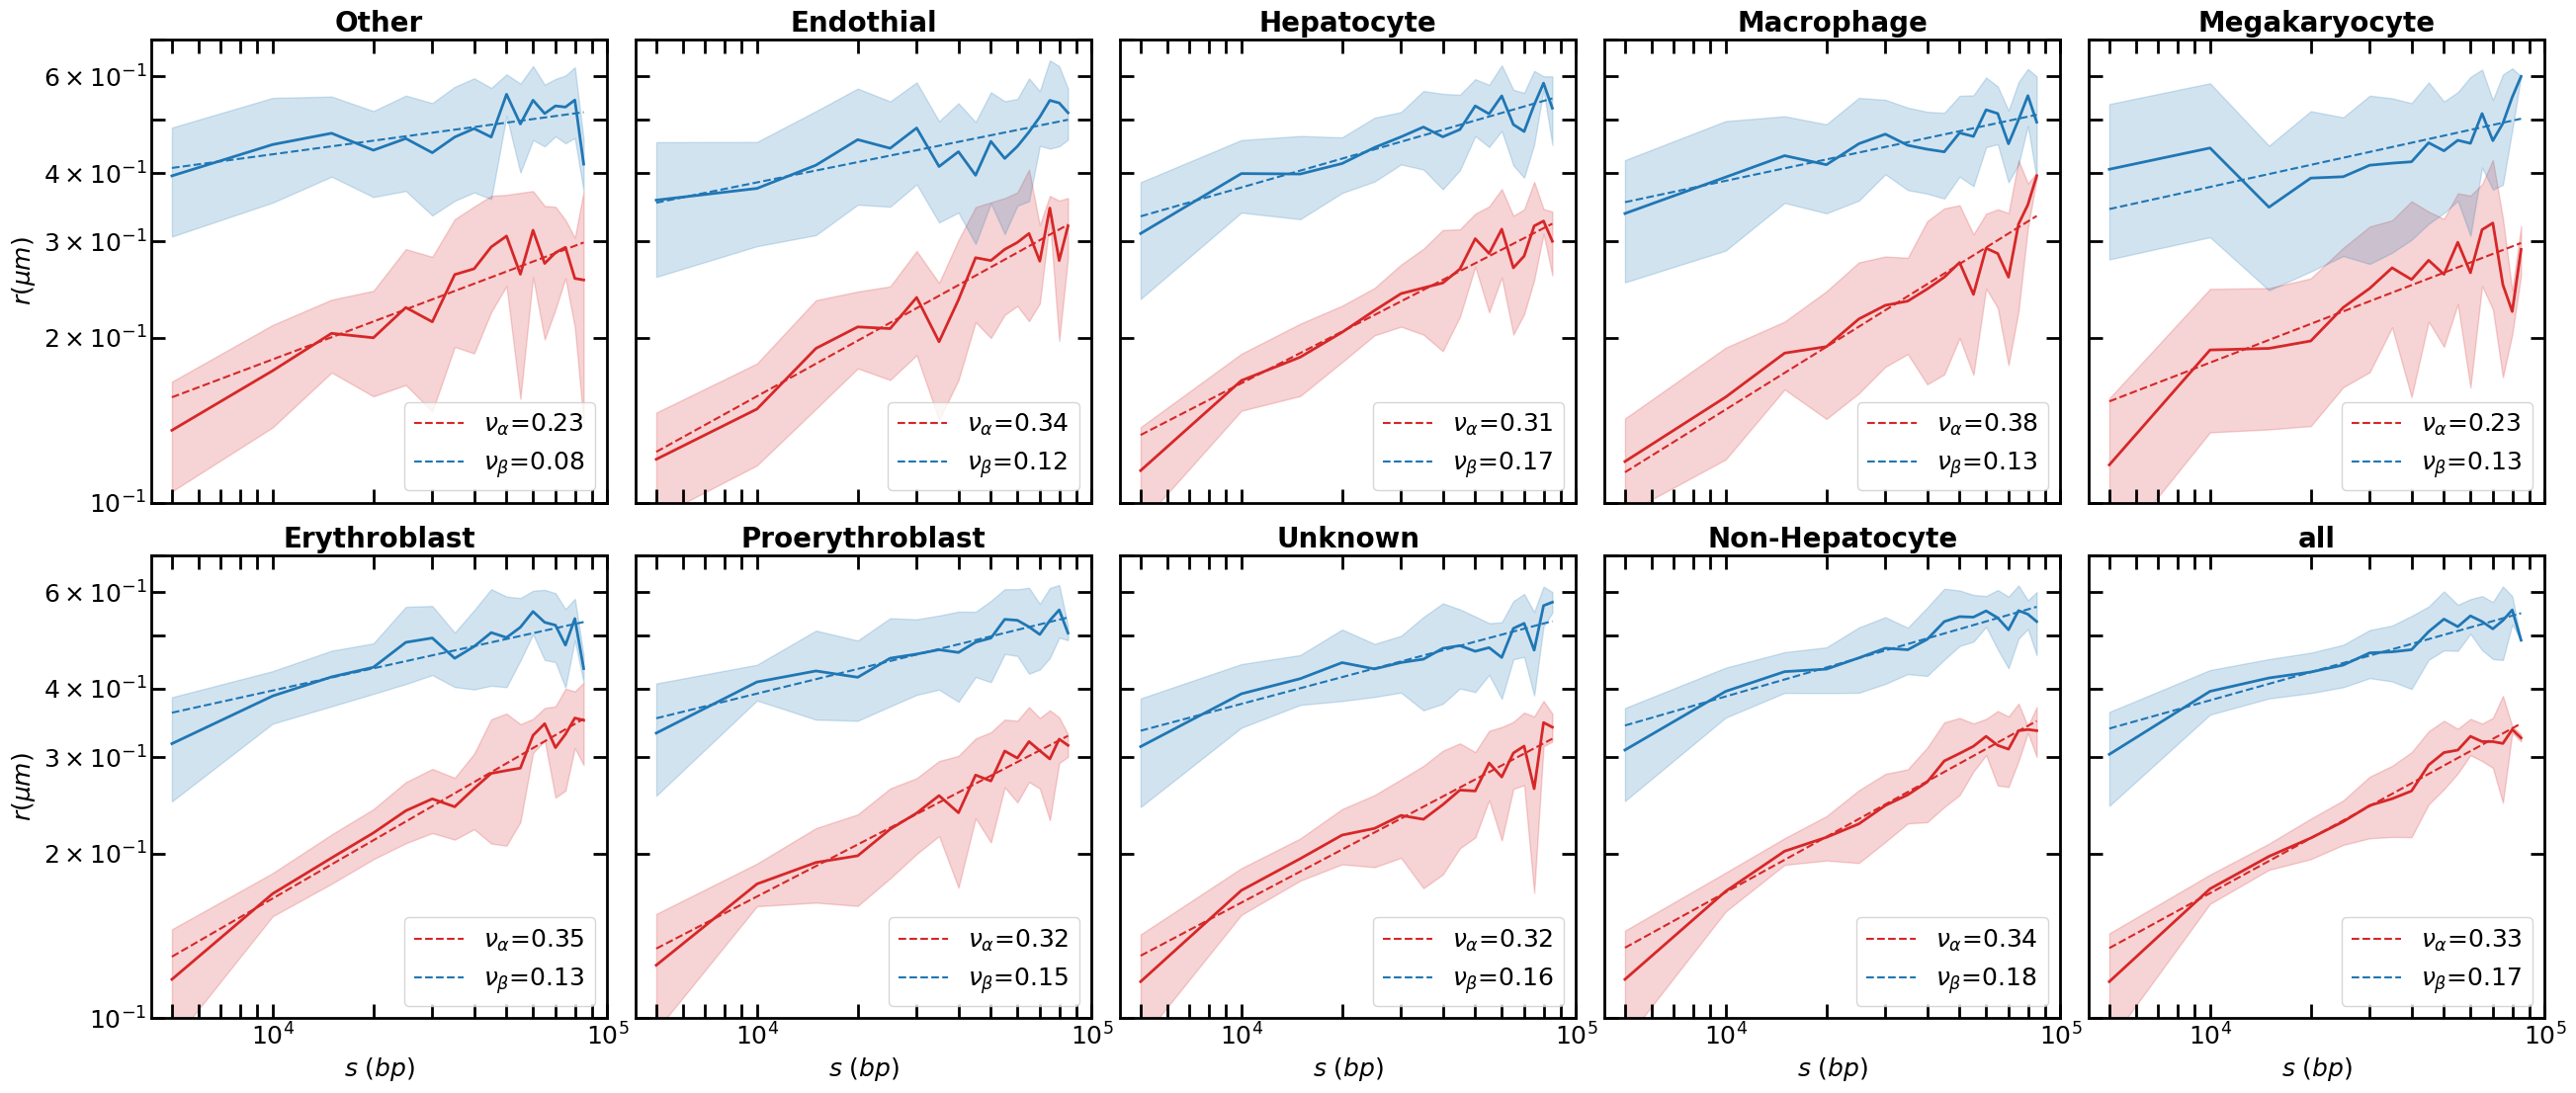

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')
# Define the color points for the custom colormap
f_colors = [(1, 0.05, 0.05), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_f_colormap"
custom_cmap_f = LinearSegmentedColormap.from_list(cmap_name, f_colors, N=n_bins)

# Define the number of cell lines
cell_lines = ['Other', 'Endothial', 'Hepatocyte', 'Macrophage', 'Megakaryocyte', 'Erythroblast', 'Proerythroblast', 'Unknown', 'Non-Hepatocyte', 'all']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 5, figsize=(26, 11), sharex='col', sharey='row')
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = cell_line
    # color = RESULTS[cell_line]['color']

    fr_vs_distance = RESULTS[cell_line]['fr_vs_distance']
    mean_values_fa = fr_vs_distance[0]
    f_lower = fr_vs_distance[1]
    f_upper = fr_vs_distance[2]

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 5000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3.5 * 10**5
    filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    ss_filtered, mean_values_Ra_filtered = filter_invalid_values(ss_filtered, mean_values_Ra_filtered)
    ss_filtered, mean_values_Rb_filtered = filter_invalid_values(ss_filtered, mean_values_Rb_filtered)

    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs[cl]
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    print('A = ', pa[0], 'B = ', pb[0], 'B/A = ', pb[0] / pa[0])

    # Plot Ra
    ax.loglog(ss, mean_values_Ra, linewidth=2, color='tab:red')
    ax.fill_between(ss, Ra_lower, Ra_upper, color='tab:red', alpha=0.2)

    # Plot Rb
    ax.loglog(ss, mean_values_Rb, linewidth=2, color='tab:blue')
    ax.fill_between(ss, Rb_lower, Rb_upper, color='tab:blue', alpha=0.2)

    # Plot Rt
    # ax.loglog(ss, mean_values_Rt, linewidth=2, color='k')
    # ax.fill_between(ss, Rt_lower, Rt_upper, color='k', alpha=0.2)
    ax.tick_params(axis='both', which='both', labelsize=18, direction='in', top=True, right=True, length=10, width=2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xscale('log')
    ax.set_ylim(0.1, 0.7)
    ax.set_xlim(0, ss.max())
    ax.legend(ncol=1, fontsize=18, loc='lower right')

    if cl in [0, 5]:
        ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
        ax.set_yticks([0.1, 0.5])
        ax.set_yticklabels([r'$0.1$', r'$0.5$'], fontsize=18)
    if cl >= 5:
        ax.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax.set_xticks([10000, 100000])
        ax.set_xticklabels([r'$10^4$', r'$10^5$'], fontsize=18)
    # 
    # Add shaded area starting from s = 500000

    ax.set_title(name, fontsize=20, fontweight='bold')
plt.tight_layout(pad=0.5)
plt.savefig("R_mean_vs_s_logscale_liu_all_samples.pdf", bbox_inches='tight')
plt.show()

A =  0.007862522376867277 B =  0.07870505353290409 B/A =  10.010153200258761


/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_2904/3525407109.py:84: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, ss.max())


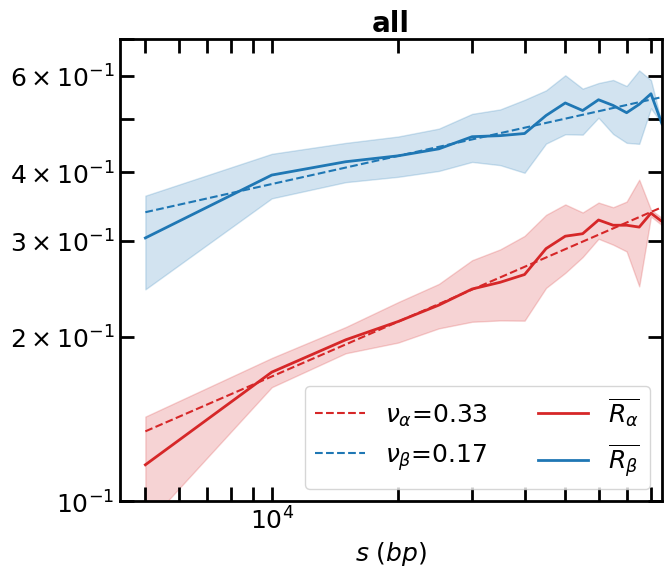

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the color points for the custom colormap
f_colors = [(1, 0.05, 0.05), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_f_colormap"
custom_cmap_f = LinearSegmentedColormap.from_list(cmap_name, f_colors, N=n_bins)

# Define the cell line
cell_line = 'all'

name = cell_line


fr_vs_distance = RESULTS[cell_line]['fr_vs_distance']
mean_values_fa = fr_vs_distance[0]
f_lower = fr_vs_distance[1]
f_upper = fr_vs_distance[2]

mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']

x_range = range(1, len(mean_values_Ra) + 1)
ss = np.array(x_range) * 5000  # Genomic distances

Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']

# Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
max_ss = 3.5 * 10**5
filtered_indices = ss <= max_ss

ss_filtered = ss[filtered_indices]
mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

ss_filtered, mean_values_Ra_filtered = filter_invalid_values(ss_filtered, mean_values_Ra_filtered)
ss_filtered, mean_values_Rb_filtered = filter_invalid_values(ss_filtered, mean_values_Rb_filtered)

# Fit the power function to the filtered data for Ra and Rb
pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

# Plot the data
fig, ax = plt.subplots(figsize=(7, 6))

ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

print('A = ', pa[0], 'B = ', pb[0], 'B/A = ', pb[0] / pa[0])

# Plot Ra
ax.loglog(ss, mean_values_Ra, linewidth=2, color='tab:red', label=r'$\overline{R_{\alpha}}$')
ax.fill_between(ss, Ra_lower, Ra_upper, color='tab:red', alpha=0.2)

# Plot Rb
ax.loglog(ss, mean_values_Rb, linewidth=2, color='tab:blue', label=r'$\overline{R_{\beta}}$')
ax.fill_between(ss, Rb_lower, Rb_upper, color='tab:blue', alpha=0.2)

# Plot Rt
# ax.loglog(ss, mean_values_Rt, linewidth=2, color='k')
# ax.fill_between(ss, Rt_lower, Rt_upper, color='k', alpha=0.2)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in', top=True, right=True, length=10, width=2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_xscale('log')
ax.set_ylim(0.1, 0.7)
ax.set_xlim(0, ss.max())
ax.legend(ncol=2, fontsize=18, loc='lower right')

if cl in [0, 5]:
    ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
    ax.set_yticks([0.1, 0.5])
    ax.set_yticklabels([r'$0.1$', r'$0.5$'])
if cl >= 5:
    ax.set_xlabel(r'$s$ ($bp$)', fontsize=18)
    # ax.set_xticks([100000, 500000])
    # ax.set_xticklabels([r'$10^5$', r'$10^6$'])

ax.set_title(name, fontsize=20, fontweight='bold')

plt.savefig("R_mean_vs_s_logscale_liu_all_set.pdf")
plt.show()

In [20]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the color points for the custom colormap
f_colors = [(1, 0.05, 0.05), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_f_colormap"
custom_cmap_f = LinearSegmentedColormap.from_list(cmap_name, f_colors, N=n_bins)

# Define the cell line
cell_line = 'all'

# Extract the relevant data
mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']

x_range = range(1, len(mean_values_Ra) + 1)
ss = np.array(x_range) * 5000  # Genomic distances

# Filter the data to include only points where ss <= 2 * 10^5
max_ss = 2 * 10**5
filtered_indices = ss <= max_ss

ss_filtered = ss[filtered_indices]
mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
mean_values_Rb_filtered = mean_values_Rb[filtered_indices]
std_values_Ra_filtered = std_values_Ra[filtered_indices]
std_values_Rb_filtered = std_values_Rb[filtered_indices]

# Save the filtered data to a text file
with open('filtered_data.txt', 'w') as f:
    f.write('ss_mouse, mean_values_Ra_filtered_mouse, mean_values_Rb_filtered_mouse, std_values_Ra_filtered_mouse, std_values_Rb_filtered_mouse\n')
    for i in range(len(ss_filtered)):
        f.write(f'{ss_filtered[i]}, {mean_values_Ra_filtered[i]}, {mean_values_Rb_filtered[i]}, {std_values_Ra_filtered[i]}, {std_values_Rb_filtered[i]}\n')

In [21]:
list(cell_lines)

['Other',
 'Endothial',
 'Hepatocyte',
 'Macrophage',
 'Megakaryocyte',
 'Erythroblast',
 'Proerythroblast',
 'Unknown',
 'Non-Hepatocyte',
 'all']

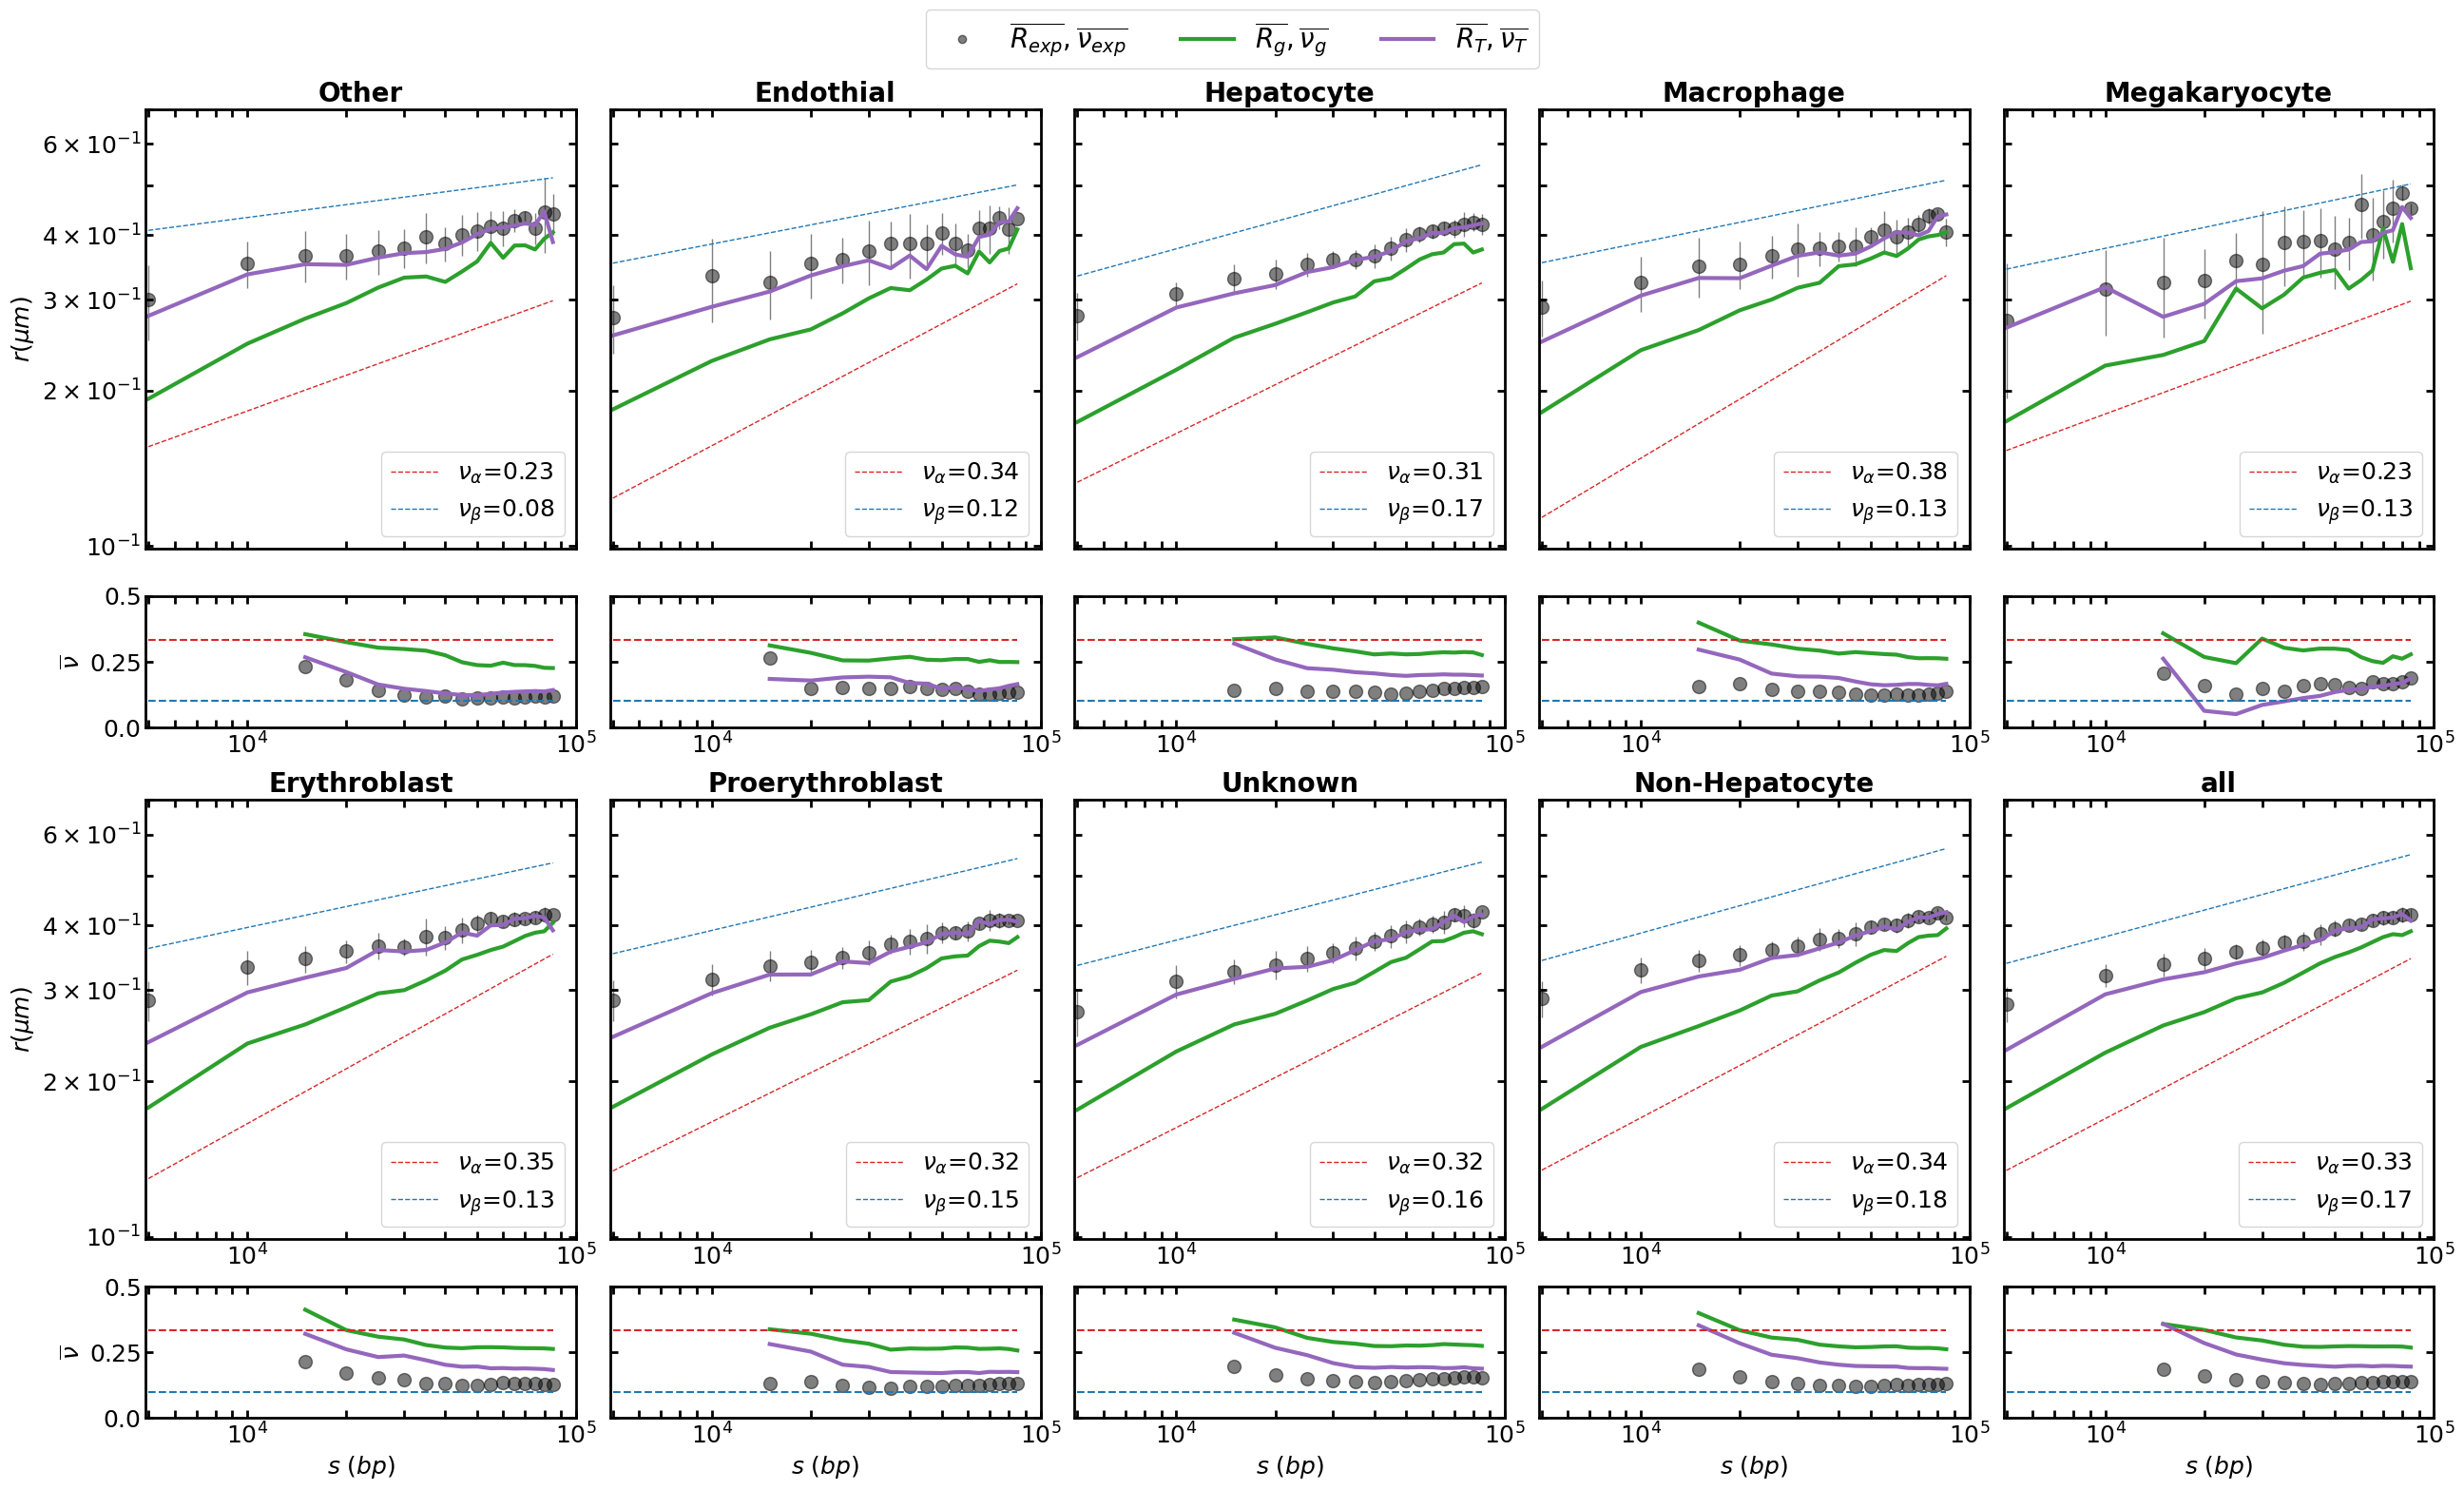

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the number of cell lines
cell_lines = ['Other', 'Endothial', 'Hepatocyte', 'Macrophage', 'Megakaryocyte', 'Erythroblast', 'Proerythroblast', 'Unknown', 'Non-Hepatocyte', 'all']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 5, figsize=(26, 15), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = cell_line

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']
    mean_values_Rg = RESULTS[cell_line]['mean_values_Rg_vs_gd']
    std_values_Rg = RESULTS[cell_line]['std_values_Rg_vs_gd']
    Reconstructed_R = RESULTS[cell_line]['Reconstructed_R_vs_gd']
    vu_T = RESULTS[cell_line]['vu_T_vs_gd']
    vu_eff = RESULTS[cell_line]['vu_eff_vs_gd']
    vu_g = RESULTS[cell_line]['vu_g_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 5000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']
    Rg_lower = RESULTS[cell_line]['Rg_lower_vs_gd']
    Rg_upper = RESULTS[cell_line]['Rg_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3.5 * 10**5
    filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs[cl]
    
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', lw=1, label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', lw=1, label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    # Plot Rt
    ax.errorbar(ss, mean_values_Rt, yerr=std_values_Rt, fmt='o', markersize=10, lw=1, color='k', alpha=0.5, zorder=1) 

    # Plot Rg
    ax.loglog(ss, mean_values_Rg, linewidth=3, color='tab:green', zorder=2) 

    # Plot Reconstructed Rt
    ax.loglog(ss, Reconstructed_R, linewidth=3, color='tab:purple', zorder=2) 

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(4900,  10**5)
    ax.legend(ncol=1, fontsize=18, loc='lower right')
    ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xticklabels([])  # Remove x-tick labels
    if cl in [0, 5]:
        ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
    ax.set_ylim(0.099, 0.7)
    ax.set_title(name, fontsize=20, fontweight='bold')
    # Remove x-tick labels for all but the bottom row
    if cl < 5:
        ax.set_xticklabels([])

    # Add secondary panel for vu_T, vu_g, and vu_eff at the bottom of the subplot
    x_range = range(1, len(vu_T) + 1)
    assert len(x_range) == len(vu_T), "x_range and vu_T must have the same length"

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="30%", pad=0.5, sharex=ax)
    ax2.plot(np.array(x_range)[2:] * 5000, vu_T[2:], 'o', markersize=10, color='k', alpha=0.5, label=r'$\nu_T$', zorder=1) 
    ax2.plot(np.array(x_range)[2:] * 5000, vu_g[2:], lw=3, color='tab:green', label=r'$\nu_g$', zorder=2) 
    ax2.plot(np.array(x_range)[2:] * 5000, vu_eff[2:], lw=3, color='tab:purple', label=r'$\nu_{eff}$', zorder=2) 
    ax2.plot(ss, [1/3]*len(ss), color='tab:red', linestyle='--', label=r'$\nu_\alpha$')
    ax2.plot(ss, [1/10]*len(ss), color='tab:blue', linestyle='--', label=r'$\nu_\beta$')
    ax2.set_ylim(-0.0001, 0.5)
    
    if cl in [0, 5]:
        ax2.set_ylabel(r'$\overline{\nu}$', fontsize=18, color='k')
        ax2.set_yticks([0, 0.25, 0.5])
        ax2.set_yticklabels([r'$0.0$', r'$0.25$', r'$0.5$'], fontsize=18)
    else:
        ax2.set_yticks([0, 0.25, 0.5])
        ax2.set_yticklabels([])
    if cl >= 5:
        ax2.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax2.set_xticks([ 10000,100000])
        ax2.set_xticklabels([r'$10^4$', r'$10^5$'], fontsize=18)
    ax2.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax2.spines['top'].set_linewidth(2)
    ax2.spines['right'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.spines['left'].set_linewidth(2)
    
    # Add shaded area starting from s = 500000
    # ax.axvspan(max_ss, 2*10**6, color='gray', alpha=0.3)

# Create a common legend for R_alpha, R_beta, and R_T outside the loop
legend_labels = [r'$\overline{R_{exp}}, \overline{\nu_{exp}}$', r'$\overline{R_{g}}, \overline{\nu_{g}}$', r'$\overline{R_{T}}, \overline{\nu_{T}}$']
handles = [Line2D([0], [0], linestyle='', lw=3, marker='o', alpha=0.5, color='k', label=legend_labels[0]),
           Line2D([0], [0], linestyle='-', lw=3, color='tab:green', label=legend_labels[1]),
           Line2D([0], [0], linestyle='-', lw=3, color='tab:purple', label=legend_labels[2])]

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=20)

plt.tight_layout(pad=1)
plt.savefig('scaling_behavior_all_liu.pdf', bbox_inches='tight')
plt.show()

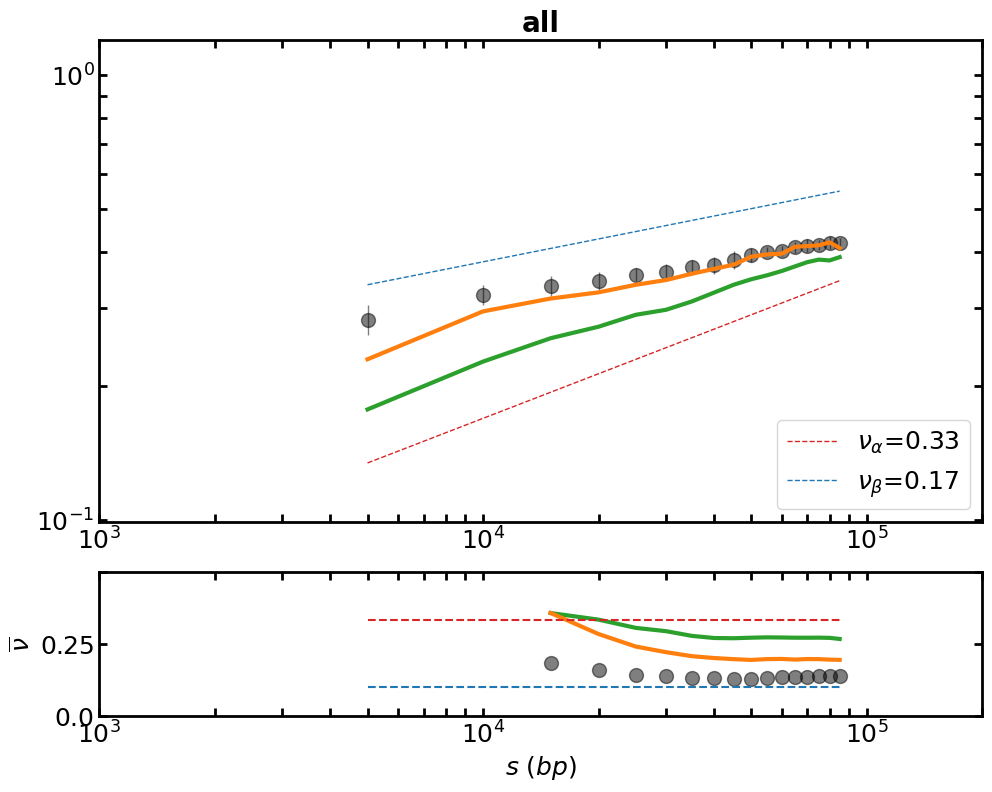

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the cell line
cell_line = 'all'

# Extract the relevant data
mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']
mean_values_Rg = RESULTS[cell_line]['mean_values_Rg_vs_gd']
std_values_Rg = RESULTS[cell_line]['std_values_Rg_vs_gd']
Reconstructed_R = RESULTS[cell_line]['Reconstructed_R_vs_gd']
vu_T = RESULTS[cell_line]['vu_T_vs_gd']
vu_eff = RESULTS[cell_line]['vu_eff_vs_gd']
vu_g = RESULTS[cell_line]['vu_g_vs_gd']

x_range = range(1, len(mean_values_Ra) + 1)
ss = np.array(x_range) * 5000  # Genomic distances

Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']
Rg_lower = RESULTS[cell_line]['Rg_lower_vs_gd']
Rg_upper = RESULTS[cell_line]['Rg_upper_vs_gd']

# Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
max_ss = 3.5 * 10**5
filtered_indices = ss <= max_ss

ss_filtered = ss[filtered_indices]
mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

# Fit the power function to the filtered data for Ra and Rb
pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', lw=1, label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', lw=1, label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

# Plot Rt
ax.errorbar(ss, mean_values_Rt, yerr=std_values_Rt, fmt='o', markersize=10, lw=1, color='k', alpha=0.5, zorder=1)

# Plot Rg
ax.loglog(ss, mean_values_Rg, linewidth=3, color='tab:green', zorder=2)

# Plot Reconstructed Rt
ax.loglog(ss, Reconstructed_R, linewidth=3, color='tab:orange', zorder=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(3000,  10**5)
ax.legend(ncol=1, fontsize=18, loc='lower right')
ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_ylim(0.099, 1.2)
ax.set_title(cell_line, fontsize=20, fontweight='bold')

# Add secondary panel for vu_T, vu_g, and vu_eff at the bottom of the subplot
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", size="30%", pad=0.5, sharex=ax)
ax2.plot(ss[2:], vu_T[2:], 'o', markersize=10, color='k', alpha=0.5, label=r'$\nu_T$', zorder=1)
ax2.plot(ss[2:], vu_g[2:], lw=3, color='tab:green', label=r'$\nu_g$', zorder=2)
ax2.plot(ss[2:], vu_eff[2:], lw=3, color='tab:orange', label=r'$\nu_{eff}$', zorder=2)
ax2.plot(ss, [1/3]*len(ss), color='tab:red', linestyle='--', label=r'$\nu_\alpha$')
ax2.plot(ss, [1/10]*len(ss), color='tab:blue', linestyle='--', label=r'$\nu_\beta$')
ax2.set_ylim(-0.0001, 0.5)

ax2.set_ylabel(r'$\overline{\nu}$', fontsize=18, color='k')
ax2.set_yticks([0, 0.25, 0.5])
ax2.set_yticklabels([r'$0.0$', r'$0.25$', ''], fontsize=18)
ax2.set_xlabel(r'$s$ ($bp$)', fontsize=18)
ax2.set_xlim(2500, 2 * 10**5)
ax2.set_xticks([1000, 10000,100000])
ax2.set_xticklabels([r'$10^3$',r'$10^4$', r'$10^5$'], fontsize=18)
ax2.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
ax2.spines['top'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

plt.tight_layout(pad=1)
plt.savefig('scaling_behavior_all_liu.pdf', bbox_inches='tight')
plt.show()

# Calculate the genomic distances
x_range = range(1, len(mean_values_Rt) + 1)
ss = np.array(x_range) * 5000  # Genomic distances

# Combine the data into a single array for saving
data_to_save = np.column_stack((ss, mean_values_Rt, std_values_Rt, vu_T))

# Save the data to a text file
np.savetxt('ss_mean_values_Rt_std_values_Rt_all.txt', data_to_save, delimiter=',', header='ss,mean_values_Rt,std_values_Rt,vu_T', comments='')

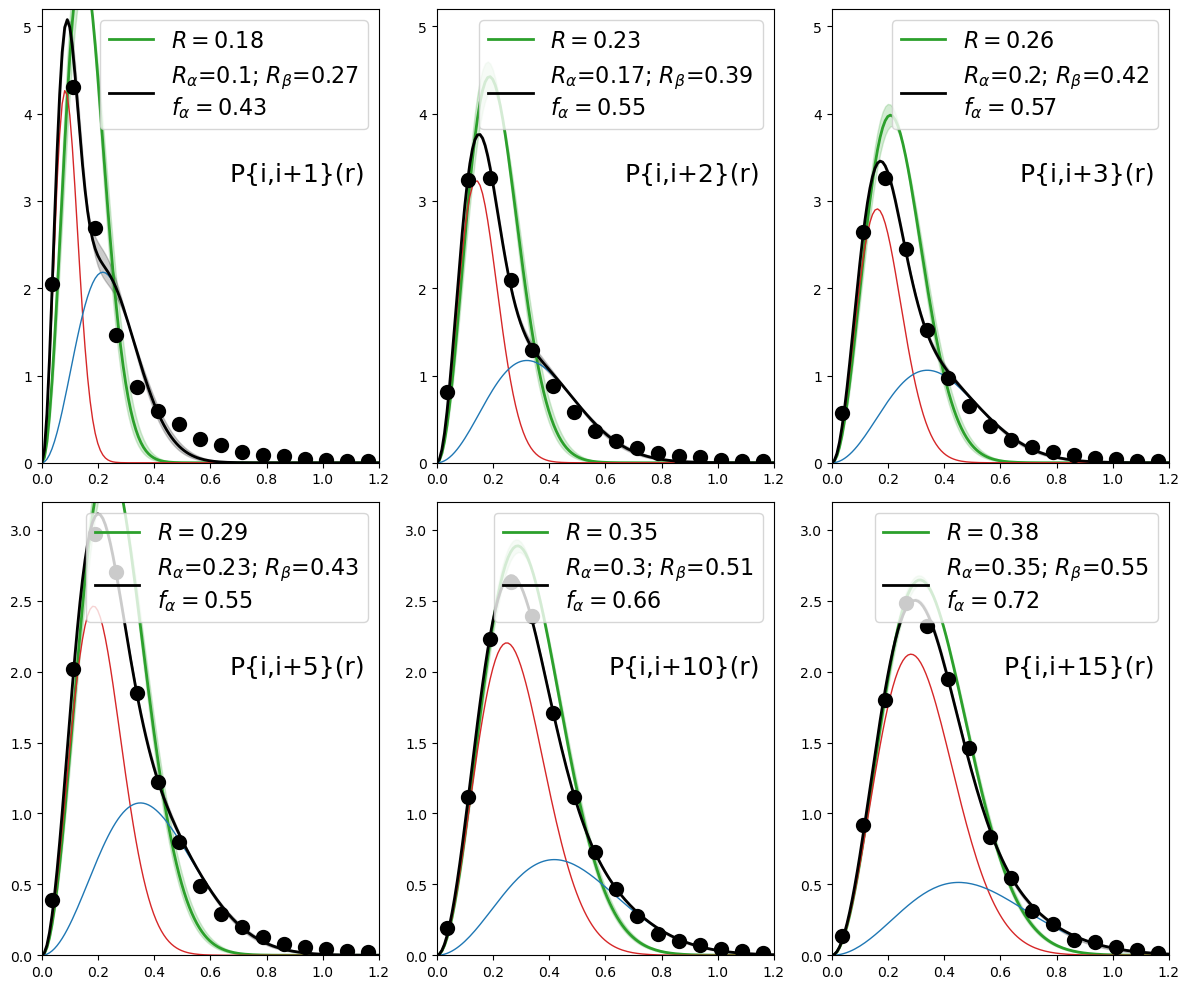

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Initialize parameters
bin_max = 1.8
nbr_bins = 25
bins = np.linspace(0, bin_max, nbr_bins)

# Define a list of tag differences to analyze
dtag = [1, 2, 3, 5, 10, 15]
# Define subplot positions for plotting
nplots = [231, 232, 233, 234, 235, 236]

# Define the cell line to analyze
cell_line = 'all'

# Get the distance matrix for the 'all' cell line
dm = RESULTS[cell_line]['distmat']

# Create a new figure for plotting
fig = plt.figure(figsize=(12, 10))

# Iterate over different tag differences (dtag)
for i, dt in enumerate(dtag):
    # Extract distances for all pairs of tags such that the difference between tags is equal to dt
    rr = []
    for tag1 in range(dm.shape[1]):
        for tag2 in range(tag1 + 1, dm.shape[1]):
            if tag2 - tag1 == dt:
                rr.extend(dm[:, tag1, tag2])
    rr = np.array(rr)

    # Create a histogram and calculate bin centers
    hist, bins = np.histogram(rr, bins=bins, density=True)
    bc = 0.5 * (bins[1:] + bins[:-1])

    # Fit a Gaussian distribution to the data
    param1, pcov1 = curve_fit(GAUSSIAN_DISTR, bc, hist, bounds=([0], [bin_max]))
    std1 = np.sqrt(np.diag(pcov1))

    # Fit a weighted combination of two Gaussian distributions to the data
    initial_guess = (0.5, 0.5, 0.5)  # Initial guesses for R1, R2, and f
    param2, pcov2 = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, p0=initial_guess, bounds=(0.05, [0.5, 0.6, 1]))
    std2 = np.sqrt(np.diag(pcov2))

    ra = param2[0]
    rb = param2[1]
    fa = param2[2]

    # Create a range for plotting
    rr_plot = np.linspace(0, 1.8, 200)

    # Add a subplot to the figure
    ax = fig.add_subplot(nplots[i])

    # Customize the first subplot with a title


    # Plot the Gaussian distribution with parameters and labels
    plt.plot(rr_plot, GAUSSIAN_DISTR(rr_plot, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)))
    plt.fill_between(rr_plot, GAUSSIAN_DISTR(rr_plot, param1[0] - std1[0]), GAUSSIAN_DISTR(rr_plot, param1[0] + std1[0]), color='tab:green', alpha=0.2)

    plt.plot(rr_plot, fa * GAUSSIAN_DISTR(rr_plot, ra), color='tab:red', lw=1)
    plt.plot(rr_plot, (1 - fa) * GAUSSIAN_DISTR(rr_plot, rb), color='tab:blue', lw=1)

    # Add labels for the weighted Gaussian distribution
    label = r'$R_\alpha$=' + str(np.round(ra, 2)) + r'; $R_\beta$=' + str(np.round(rb, 2)) + '\n' + r'$f_\alpha=$' + str(np.round(fa, 2))
    plt.plot(rr_plot, TWO_GAUSSIAN_DISTR(rr_plot, *param2), c='black', lw=2, label=label)
    plt.fill_between(rr_plot, TWO_GAUSSIAN_DISTR(rr_plot, *(param2 - std2)), TWO_GAUSSIAN_DISTR(rr_plot, *(param2 + std2)), color='black', alpha=0.2)

    # Plot the data points
    plt.plot(bc, hist, 'o', ms=8, mew=3, mec='black', c='black')

    # Customize plot limits and legend position
    plt.xlim([0, 1.2])
    if nplots[i] in [231, 232, 233]:
        plt.ylim([0, 5.2])
    if nplots[i] in [234, 235, 236]:
        plt.ylim([0, 3.2])
    plt.legend(loc='upper right', fontsize=16)

    # Add text with tag information
    plt.text(0.96, 0.62, r'P{i,i+'+ str(dt)+'}(r)', transform=ax.transAxes, fontsize=18, ha='right')

# Adjust the layout for better presentation
plt.tight_layout()


# Uncomment the following line to save the plot as an SVG file
# plt.savefig(f'{name}_distr.svg', facecolor='white', dpi=500)

# Display the plot
plt.show()

15


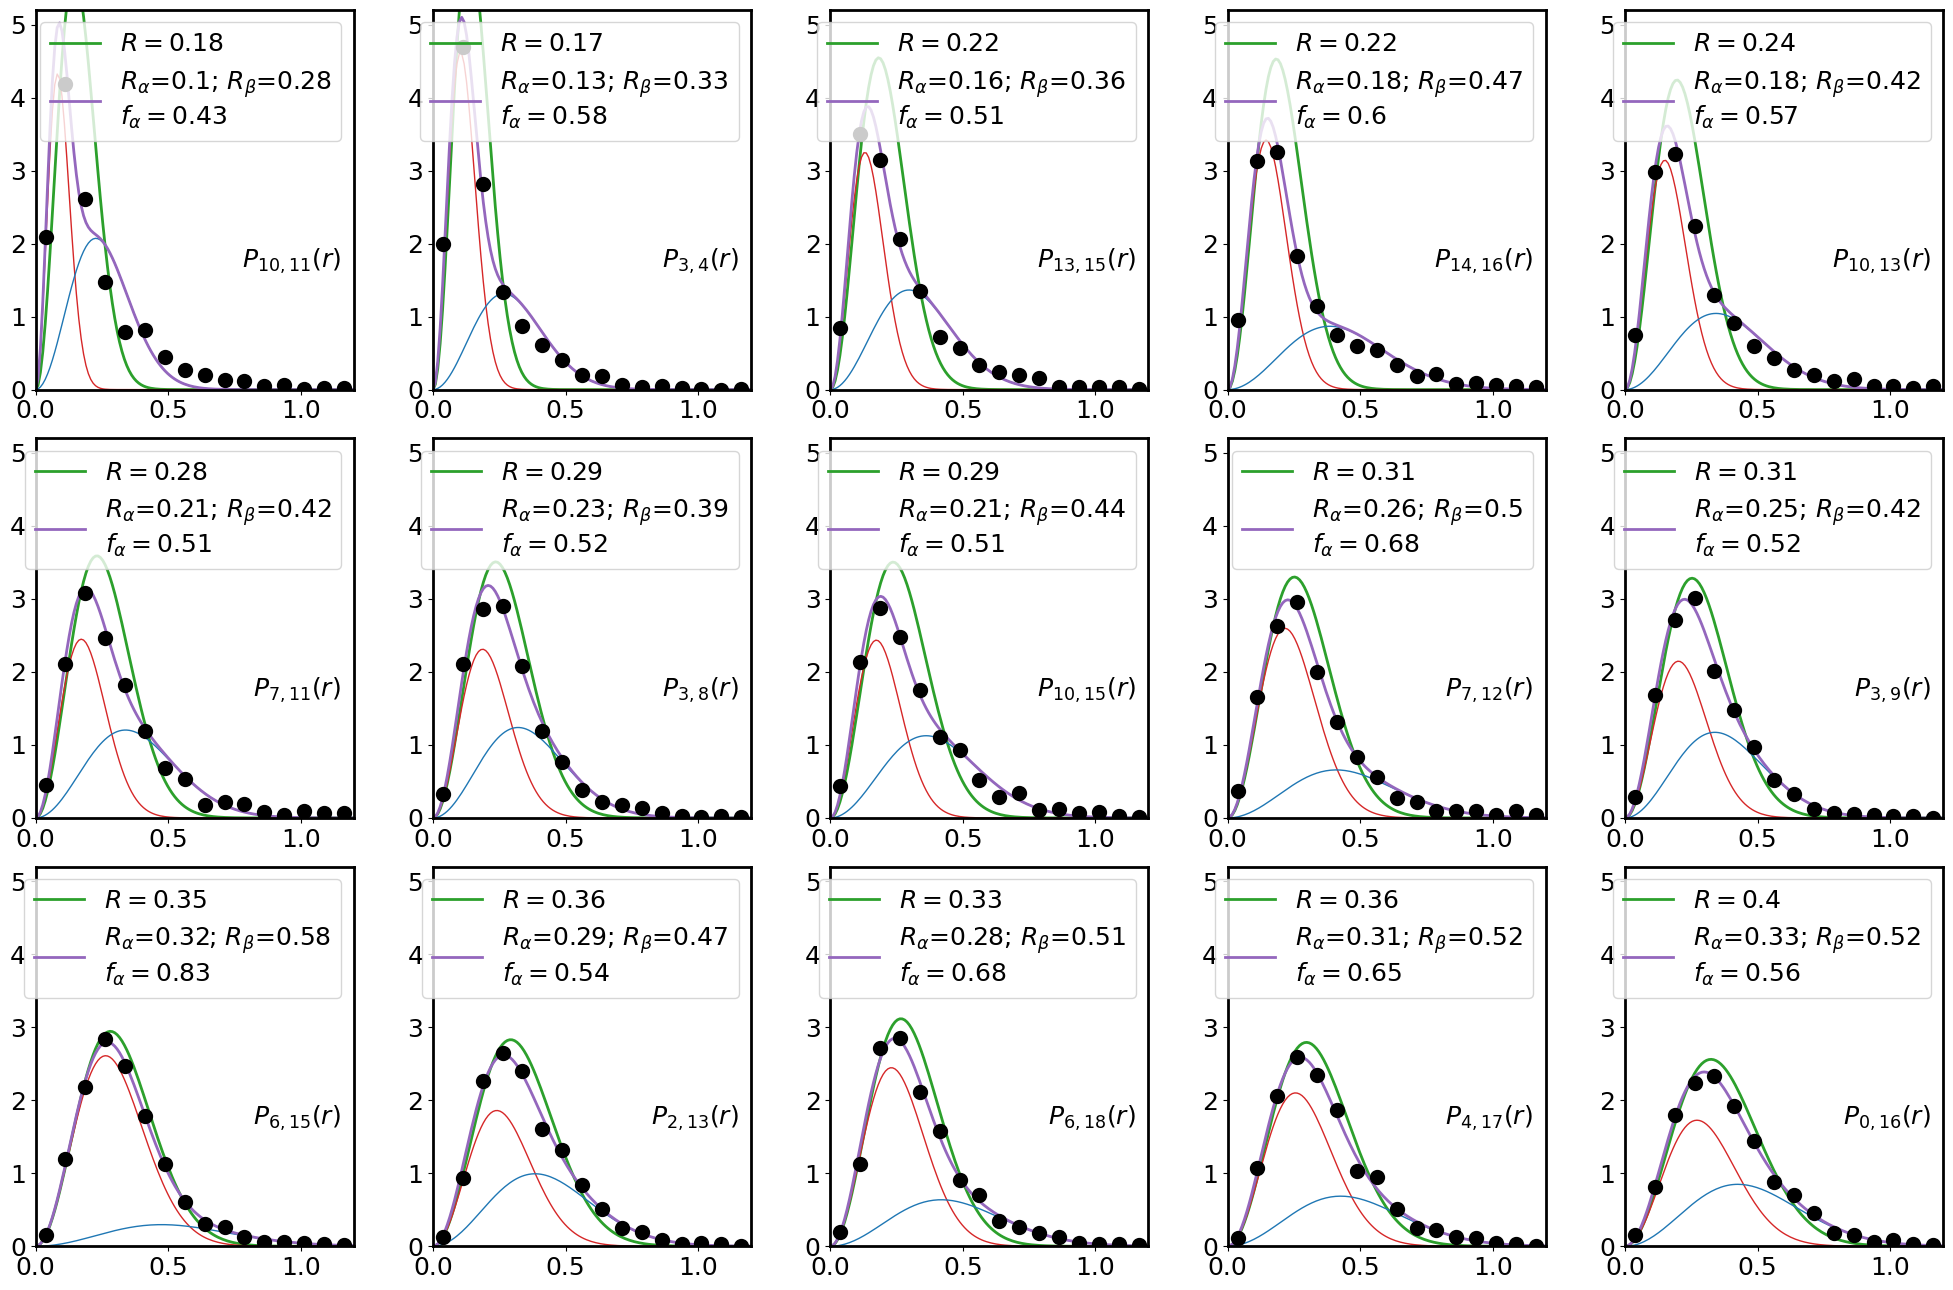

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Initialize parameters
bin_max = 1.8
nbr_bins = 25
bins = np.linspace(0, bin_max, nbr_bins)

# Define the number of random pairs to analyze
num_pairs = 15

# Define the cell line to analyze
cell_line = 'all'

# Get the distance matrix for the 'all' cell line
dm = RESULTS[cell_line]['distmat']

# Select random pairs of indices
np.random.seed(42)  # For reproducibility
n = dm.shape[1]

# Ensure num_pairs does not exceed the possible unique pairs
max_pairs = n * (n - 1) // 2
num_pairs = min(num_pairs, max_pairs)

# Generate all possible unique pairs of indices
all_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]
random_indices = np.random.choice(len(all_pairs), num_pairs, replace=False)
selected_pairs = [all_pairs[idx] for idx in random_indices]
arranged_pairs = sorted(selected_pairs, key=lambda pair: abs(pair[1] - pair[0]))

print(len(selected_pairs))

# Create a new figure for plotting
fig, axes = plt.subplots(3, 5, figsize=(20, 13))
axes = axes.flatten()

# Iterate over the arranged indices and plot the fitted PDFs
for ax, (i, j) in zip(axes, arranged_pairs):
    distances = dm[:, i, j]
    hist, bin_edges = np.histogram(distances, bins=bins, density=True)
    bc = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit a Gaussian distribution to the data
    param1, pcov1 = curve_fit(GAUSSIAN_DISTR, bc, hist, bounds=([0], [bin_max]))
    std1 = np.sqrt(np.diag(pcov1))

    # Fit a weighted combination of two Gaussian distributions to the data
    initial_guess = (0.5, 0.5, 0.5)  # Initial guesses for R1, R2, and f
    param2, pcov2 = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, p0=initial_guess, bounds=(0.05, [0.5, 0.6, 1]))
    std2 = np.sqrt(np.diag(pcov2))

    ra = param2[0]
    rb = param2[1]
    fa = param2[2]

    # Create a range for plotting
    rr_plot = np.linspace(0, 1.8, 200)

    # Plot the Gaussian distribution with parameters and labels
    ax.plot(rr_plot, GAUSSIAN_DISTR(rr_plot, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)))
    # ax.fill_between(rr_plot, GAUSSIAN_DISTR(rr_plot, param1[0] - std1[0]), GAUSSIAN_DISTR(rr_plot, param1[0] + std1[0]), color='tab:green', alpha=0.2)

    ax.plot(rr_plot, fa * GAUSSIAN_DISTR(rr_plot, ra), color='tab:red', lw=1)
    ax.plot(rr_plot, (1 - fa) * GAUSSIAN_DISTR(rr_plot, rb), color='tab:blue', lw=1)

    # Add labels for the weighted Gaussian distribution
    label = r'$R_\alpha$=' + str(np.round(ra, 2)) + r'; $R_\beta$=' + str(np.round(rb, 2)) + '\n' + r'$f_\alpha=$' + str(np.round(fa, 2))
    ax.plot(rr_plot, TWO_GAUSSIAN_DISTR(rr_plot, *param2), c='tab:purple', lw=2, label=label)
    # ax.fill_between(rr_plot, TWO_GAUSSIAN_DISTR(rr_plot, *(param2 - std2)), TWO_GAUSSIAN_DISTR(rr_plot, *(param2 + std2)), color='black', alpha=0.2)

    # Plot the data points
    ax.plot(bc, hist, 'o', ms=8, mew=3, mec='black', c='black')

    # Customize plot limits and legend position
    ax.set_xlim([0, 1.2])
    ax.set_ylim([0, 5.2])
    ax.legend(loc='upper right', fontsize=18)

    # Add text with tag information
    ax.text(0.96, 0.32, rf'$P_{{{i},{j}}}(r)$', transform=ax.transAxes, fontsize=18, ha='right')

    # Set the color of the spines to black and linewidth to 2
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

    # Set the font size for the tick labels
    ax.tick_params(axis='both', which='major', labelsize=18)

    # Remove the grid
    ax.grid(False)

# Adjust the layout for better presentation
plt.tight_layout()

# Uncomment the following line to save the plot as an SVG file
# plt.savefig(f'{name}_distr.svg', facecolor='white', dpi=500)
plt.savefig('random_pairs_distr_mouse.pdf', bbox_inches='tight')
# Display the plot
plt.show()